In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyper-paramters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Dataset has PILImage images of range [0, 1].
# It will transform them to Tensors of normalized [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [12:26<00:00, 228275.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
%%time
def imshow(imgs):
    imgs = imgs / 2 + 0.5
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


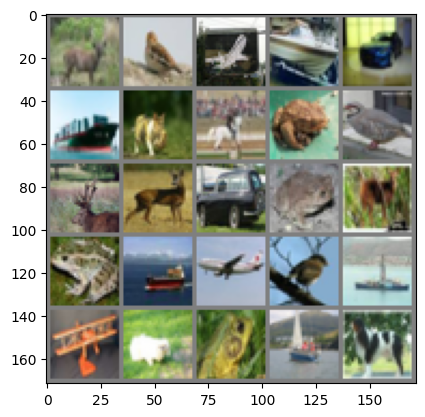

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

In [25]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        # N (batch size), 3 colors channels, 32 nb pixel width, 32 nb pixel height
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [26]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = .0
    
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {running_loss / n_total_steps}')
print('Finished Training')

1563it [00:36, 43.34it/s]


Epoch 1/10 | Loss: 0.9375284912680787


1563it [00:31, 49.60it/s]


Epoch 2/10 | Loss: 0.8300148081260847


1563it [00:30, 51.16it/s]


Epoch 3/10 | Loss: 0.7574797216242731


1563it [00:31, 50.15it/s]


Epoch 4/10 | Loss: 0.6985007031979807


1563it [00:30, 50.99it/s]


Epoch 5/10 | Loss: 0.6533251288355884


1563it [00:30, 50.57it/s]


Epoch 6/10 | Loss: 0.6067027398602595


1563it [00:30, 50.72it/s]


Epoch 7/10 | Loss: 0.5677070430815411


1563it [00:28, 54.03it/s]


Epoch 8/10 | Loss: 0.5300752584436957


1563it [00:30, 50.80it/s]


Epoch 9/10 | Loss: 0.4945592940692633


1563it [00:28, 54.20it/s]

Epoch 10/10 | Loss: 0.46621579470938773
Finished Training


In [37]:
MODEL_PATH = './models/cnn.pth'
torch.save(model.state_dict(), MODEL_PATH)

In [40]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [42]:
with (torch.no_grad()):
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)
    print(n_samples)
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted == labels).sum().item()
        
    accuracy = n_correct / n_samples * 100
    accuracy2 = n_correct2 / n_samples * 100
    print('Accuracy:', accuracy, ' loaded model accuracy:', accuracy2)
        


10000
Accuracy: 72.19  loaded model accuracy: 72.19
